# Non-Negative Matrix Factorization applications.

In this notebook we try to use our implementations of Non-Negative Matrix Factorization for three purposes :
    - a simple analysis of our implementations
    - a recommender algorithms for movies based on users ratings of different movies
    - faces recognition

The two implementations of NMF respectively try to minimize  :
    - Kullback-Leibler divergence (see kul_mul.py)
    - Frobenius distance (see fro_mul.py)

In [4]:
import numpy as np
import scipy.io as sio
import numpy as np
from kul_mul import *
from fro_mul import *
from monitor import *
import pandas as pd

/anaconda3/envs/ML/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Analysis of the NMF implementations

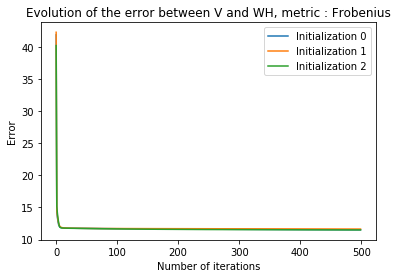

In [5]:
# Sensitivity to initialization for the algo minimizing Frobenius distance
r = 5
n = 1000
p = 100
V = np.random.rand(n, p)
to_compare = []
amps = [1, 10, 20]
for i in range(len(amps)):
    W_init, H_init = amps[i]*np.random.rand(n, r), amps[i]*np.random.rand(r, p)
    froNMF = FrobeniusNMF(V=V,r=r, W_init=W_init, H_init=H_init)
    to_compare.append(froNMF)

monitor_fro = Monitor(algos=to_compare, metric = 'Frobenius', niter=500)
monitor_fro.plot_error(labels = ['Initialization ' + str(i) for i in range(len(amps))])

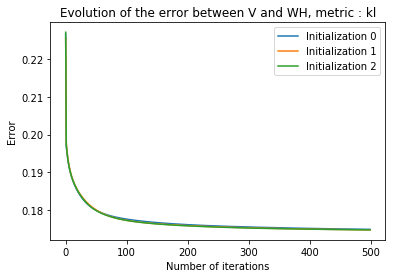

In [66]:
# Sensitivity to initialization for the algo minimizing Kullbach-Leibler divergence
r = 7
n = 1000
p = 100
V = np.random.rand(n, p)
to_compare_kl = []
amps = [1, 10, 20]
for i in range(len(amps)):
    W_init, V_init = amps[i]*np.random.rand(n, r), amps[i]*np.random.rand(r, p)
    kNMF = KullbachNMF(V=V,r=r)
    to_compare_kl.append(kNMF)

monitor_kl = Monitor(algos=to_compare_kl, metric = 'kl', niter=500)
monitor_kl.plot_error(labels = ['Initialization ' + str(i) for i in range(len(amps))])

In [7]:
# comparing the different solutions provided for each initialization
for i in range(len(monitor_fro.algos)) :
    for j in range(i + 1, len(monitor_fro.algos)) :
        print('Frobenius norm between the results after initializations {} and {}'.format(i,j),
              np.linalg.norm(monitor_fro.algos[i].V_hist[-1] - monitor_fro.algos[j].V_hist[-1]))

Frobenius norm between the results after initializations 0 and 1 24.260865787989108
Frobenius norm between the results after initializations 0 and 2 20.599928454086356
Frobenius norm between the results after initializations 1 and 2 22.587990921510112


## Comparison of our NMF with sklearn's NMF

The first thing to notice is that our two algos, minimizing respectively the frobenius norm and the Kulbach-Leibler divergence make them decrease at each step.

However, by initializing differently W and H, we could expect that the algos converge towards different solutions since theory guarantees that the algos converge towards a local minima and not a global one.

In [69]:
'''sklearn implements an NMF in its module sklearn.decomposition, let s compare it with our own implementation. 
The distance to minimize used in sklearn s nmf is the Frobenius norm, so we compare it to our 
implementation FroNMF. Sklearn implements two solvers : multiplicative updates (which is ours) and coordinate descent '''
from sklearn.decomposition import NMF

r = 10
n = 1000
p = 100
niter = 200
tests = 20
errors = {}
errors['sklearn'] = []
errors['FrobeniusNMF'] = []
for _ in range(tests) :
    V = np.random.rand(n, p)
    nmf_sk = NMF(n_components=r, solver='mu')
    fro_nmf = FrobeniusNMF(V = V, r=r)
    W_sk = nmf_sk.fit_transform(V)
    H_sk = nmf_sk.components_
    fro_nmf.train(niter = 200, verbose = False)
    errors['sklearn'].append(np.linalg.norm(V - W_sk @ H_sk))
    errors['FrobeniusNMF'].append(np.linalg.norm(V - fro_nmf.w_hist[-1] @ fro_nmf.h_hist[-1]))
    
print('Mean error (Frobenius) for sklearn implementation : {}'.format(np.mean(errors['sklearn'])))
print('Mean error (Frobenius) for the FrobeniusNMF implementation : {}'.format(np.mean(errors['FrobeniusNMF'])))

Mean error (Frobenius) for sklearn implementation : 85.91436953633269
Mean error (Frobenius) for the FrobeniusNMF implementation : 84.8561270342711


That is quite reassuring concerning our implementation of the NMF.

## Application of Non-Negative Matrix Factorization to Recommender System

The dataset studied here is taken from https://grouplens.org/datasets/movielens/ . It is a dataset composed of 1M ratings of 4000 movies by 6000 users.
There are actually three datasets :
    - the ratings containing the UserID, the MovieID and the rating of each user for that movie.
    - the users list containing information on each user, that we don't use here.
    - the movies list containing information on each movie (it relates the movie ID to more general information).
    
Basically, what we want to do here is a matrix completion : if we look at the matrix containing all the users ratings for all movies, some cells are empty (because a user has not seen and rated every movie in the database). The idea is to reconstruct the rating he would give to suggest him movies that he would like.
    

In [8]:
ratings_list = [i.strip().split("::") for i in open('data/ml-1m/ratings.dat', 'r').readlines()]
users_list = [i.strip().split("::") for i in open('data/ml-1m/users.dat', 'r').readlines()]
movies_list = [i.strip().split("::") for i in open('data/ml-1m/movies.dat', 'r', errors='ignore').readlines()]

In [9]:
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

In [10]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [11]:
print(ratings_df.shape)

(1000209, 4)


In [12]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
print(movies_df.shape)

(3883, 3)


In the next cell, we build a Dataframe containing :
    - UserID's as rows
    - MovieID's as columns
so that the cell $df[i,j]$ contains the rating of user $i$ for movie $j$.
When user $i$ has not rated movie j, we put a 0 in $df[i,j]$

In [14]:
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In order that each user has the same distribution for the ratings (at least the same mean, we need to rescale them)

In [15]:
from sklearn.preprocessing import MinMaxScaler
nrows, ncols = R_df.shape
scaler = MinMaxScaler()
R_scaled = scaler.fit_transform(R_df)

In [16]:
print('nrows: ', nrows)
print('ncols: ', ncols)

nrows:  6040
ncols:  3706


In [17]:
print(R_scaled)

[[1.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.6 0.  0.  ... 0.  0.  0. ]]


## Factorization

In [18]:
niter = 100
r = 50
froNMF = FrobeniusNMF(V=R_scaled, r=r)
froNMF.train(niter=niter, verbose=True)
W, H = froNMF.W, froNMF.H

Iter n° 0
Iter n° 10
Iter n° 20
Iter n° 30
Iter n° 40
Iter n° 50
Iter n° 60
Iter n° 70
Iter n° 80
Iter n° 90


In [19]:
print('Shape of W : ', W.shape)
print('Shape of H : ',H.shape)

Shape of W :  (6040, 50)
Shape of H :  (50, 3706)


We are now able to get all the users' predicted ratings :

In [20]:
predicted_ratings = W @ H
# We rescale the predicted_ratings :
predicted_ratings = scaler.inverse_transform(predicted_ratings)
predicted_ratings = pd.DataFrame(predicted_ratings, columns=R_df.columns)

In [21]:
predicted_ratings.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.151670,0.490849,0.005737,0.000650,1.534702e-02,0.007271,1.638766e-02,0.155994,6.836960e-14,0.083313,...,0.000118,0.001775,0.021956,7.880642e-07,0.001492,0.174496,0.003382,0.005279,5.900312e-07,0.000016
1,0.985250,0.205793,0.372086,0.100347,7.389321e-02,0.911421,5.883028e-02,0.025821,2.922268e-01,1.383721,...,0.002272,0.000001,0.000028,5.050625e-02,0.017879,0.112364,0.000062,0.000122,1.491641e-10,0.037828
2,1.789654,0.176532,0.081788,0.001757,9.273722e-03,0.134944,6.295174e-03,0.028660,2.682364e-02,0.516473,...,0.003515,0.000111,0.007618,5.328774e-03,0.011069,0.149575,0.007284,0.000856,5.335233e-04,0.005308
3,0.226003,0.069382,0.043550,0.000867,6.783474e-08,0.279951,1.275077e-07,0.003644,1.793075e-09,0.163403,...,0.000942,0.000040,0.003824,1.029324e-04,0.011028,0.045127,0.007190,0.005793,2.084775e-03,0.003978
4,0.999498,0.128326,0.015309,0.090724,3.126034e-03,1.406536,9.492903e-03,0.020226,7.995184e-08,0.684966,...,0.121860,0.004022,0.000747,1.163787e-02,0.004905,0.118552,0.909110,0.086537,2.096647e-01,0.399966


In [22]:
def recommend(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5) :
    user_row_number = userID - 1
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    sorted_movie_id = sorted_user_predictions
    user_data = original_ratings_df[original_ratings_df.UserID == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'MovieID', right_on = 'MovieID').
                     sort_values(['Rating'], ascending=False)
                 )
    print('User {} has already rated {} movies.'.format(userID, user_full.shape[0]))
    print('Recommending the highest {} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['MovieID'].isin(user_full['MovieID'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'MovieID',
               right_on = 'MovieID').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [23]:
user_full, recommendations = recommend(predicted_ratings, userID=32, movies_df=movies_df, original_ratings_df=ratings_df)

User 32 has already rated 48 movies.
Recommending the highest 5 predicted ratings movies not already rated.


In [24]:
recommendations

,MovieID,Title,Genres
1175,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
308,318,"Shawshank Redemption, The (1994)",Drama
1116,1148,"Wrong Trousers, The (1993)",Animation|Comedy
252,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
1162,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War


In [25]:
user_full

,UserID,MovieID,Rating,Timestamp,Title,Genres
22,32,32,5,978121599,Twelve Monkeys (1995),Drama|Sci-Fi
25,32,3072,5,978118683,Moonstruck (1987),Comedy
45,32,2108,5,978122598,L.A. Story (1991),Comedy|Romance
16,32,1296,5,978122520,"Room with a View, A (1986)",Drama|Romance
40,32,2020,5,978121545,Dangerous Liaisons (1988),Drama|Romance
27,32,3147,5,978123863,"Green Mile, The (1999)",Drama|Thriller
8,32,593,5,978123515,"Silence of the Lambs, The (1991)",Drama|Thriller
21,32,2762,5,978121626,"Sixth Sense, The (1999)",Thriller
29,32,3079,5,978122813,Mansfield Park (1999),Drama
30,32,2858,4,978119364,American Beauty (1999),Comedy|Drama


# Application of Non-Negative Matrix Factorization to Face Recognition

In [35]:
import scipy.io as sio
import scipy.misc as smp
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2

The dataset we use here is composed of 10 different face pictures of 40 different people.
The idea here is to build a classifier based on Non Negative Matrix factorization for face recognition.


(112, 92, 3)


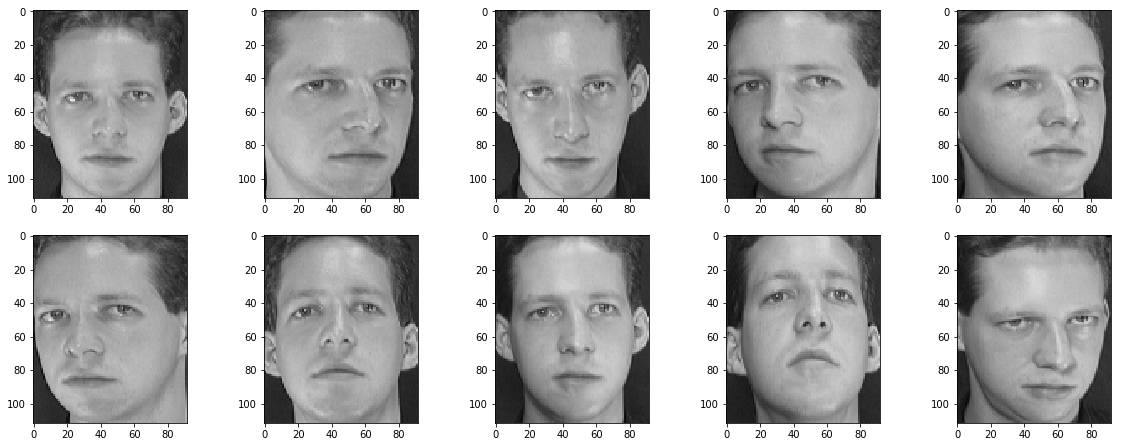

In [36]:
# Let's see some images from the dataset
fig = plt.figure(figsize=(20, 20))
for i in range(1, 11) :
    img = cv2.imread('data/orl_faces/s1/{}.pgm'.format(i))
    fig.add_subplot(5, 5, i)
    plt.imshow(img)
print(img.shape)

In [37]:
'''We first build a train and test set : we select 7 pictures for each individual for the train set and keep the 
3 others for the test set. We keep in memory a number for each picture which represent the subject'''

def build_sets(path, new_shape = (32, 32), train_size = 7):
    x_tr = np.zeros((train_size*40, new_shape[0]*new_shape[1]))
    y_tr = []
    x_te = np.zeros(((10-train_size)*40, new_shape[0]*new_shape[1]))
    y_te = []
    ind_tr = 0
    ind_te = 0
    for i in range(1, 41) :
        for j in range(1, 11) :
            img = cv2.imread(path + '/orl_faces/s{}/{}.pgm'.format(i, j))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, new_shape)
            img = img.reshape((new_shape[0]*new_shape[1]))
            if j <= train_size :
                x_tr[ind_tr, :] = img
                y_tr.append(i)
                ind_tr += 1
            else :
                x_te[ind_te, :] = img
                y_te.append(i)
                ind_te += 1
    return x_tr/255., x_te/255., np.array(y_tr), np.array(y_te)

In [38]:
'''We now have 4 datasets :
    - x_tr/te where rows number i correspond to a 32*32 image of a patient
    - y_tr where the ith element answers the question : which face is it'''

from sklearn.utils import shuffle

x_tr, x_te, y_tr, y_te = build_sets(path='data/')
x_tr, y_tr = shuffle(x_tr, y_tr)
x_te, y_te = shuffle(x_te, y_te)

In [39]:
import seaborn as sns

In [40]:
'Wxe do a TSNE to have an idea of the data representation in 2D'
from sklearn.manifold import TSNE
x_tr_embedded = TSNE().fit_transform(x_tr)

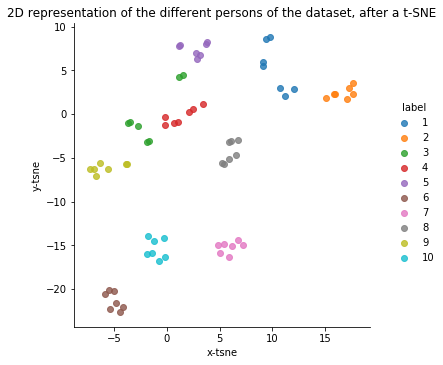

In [41]:
'We only keep 10 different persons in order to have a clearer representation'
df_tsne = pd.DataFrame()
df_tsne['x-tsne'] = x_tr_embedded[y_tr <= 10,0]
df_tsne['y-tsne'] = x_tr_embedded[y_tr<= 10,1]
df_tsne['label'] = y_tr[y_tr<=10]

sns.lmplot(x='x-tsne', y = 'y-tsne', fit_reg=False, data=df_tsne, hue='label')
plt.title('2D representation of the different persons of the dataset, after a t-SNE')
plt.show()


In [42]:
print(x_tr.shape)

(280, 1024)


In [44]:
'''We are now ready to proceed to the NMF decomposition of x_tr'''
niter = 200
froNMF = FrobeniusNMF(V=x_tr, r=30)
froNMF.train(niter = niter, verbose = False)
print('NMF with Frobenius norm done')
#
kulNMF = KullbachNMF(V=x_tr, r=30)
kulNMF.train(niter = niter, verbose = False)
print('NMF with kulbach divergence done')

NMF with Frobenius norm done
NMF with kulbach divergence done


In [45]:
# To evaluate our nmf on the test set we need to rebuild W_te thanks to H_tr and x_te
def build_W_te(h_tr, x_te) :
    h_tr_ = h_tr.copy()
    h_tr_pinv = np.linalg.pinv(h_tr_)
    w_te = x_te @ h_tr_pinv
    return w_te

In [46]:
W_tr_fro, H_tr_fro = froNMF.W, froNMF.H
W_tr_kul, H_tr_kul = kulNMF.W, kulNMF.H

In [47]:
W_te_kul = build_W_te(H_tr_kul, x_te)
W_te_fro = build_W_te(H_tr_fro, x_te)

In [48]:
from sklearn.neighbors import KNeighborsClassifier

clf_fro = KNeighborsClassifier(n_neighbors=1)
clf_fro.fit(W_tr_fro, y_tr)
clf_kul = KNeighborsClassifier(n_neighbors=1)
clf_kul.fit(W_tr_kul, y_tr)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [49]:
print(clf_fro.predict(W_te_fro))
print(clf_kul.predict(W_te_kul))

[39 32  5 11 14 33  2 31  7 38 27 12 22  8 18 34 26 30 35 18 17 13 10 40
 16 31 14 38 32  4 33 36 24 16 19 14  7  2 19 31 40 27 20 13 30 28 19 36
 11 21 24  1 38 15 27 38 39 12 32  7 22  6 21 20 36  3 25  2 40  4  6 17
  9 30 13 35 26 37  9  5  9 18 29 25 15 10 37 22 21 15 37 30 34  1 29  8
 28 33 39 34 37 18 25 20  3 11  1 12 23  6  3 17 23 26 14  8 29 35 24  4]
[39 32  5 11 11 33  2 31  7 38 27 12 22  8 18 34 26 30 35 18 17 13  9 40
 16 31 14  8 32  4 33 36 24 16 19 14  7  2  3 31 40 27 20 13 30 28 19 17
 11 21 24 24 38 15 27 38 39 12 32  7 22  6 21 20 36  3 25  2 40  4  6 17
  9 38 13 35 26 37  9  5  9 18 29 25 15 10 37 22 21 15 37 30 34  1 29  8
 28 33 39 34 37 40 25 20  3 11  1 12 23  6  3 17 23 26 14  8 29 35 24  4]


In [174]:
print('Accuracy with Frobenius norm', clf_fro.score(W_te_fro, y_te))
print('Accuracy with Kulbach divergence', clf_kul.score(W_te_kul, y_te))

Accuracy with Frobenius norm 0.925
Accuracy with Kulbach divergence 0.9


## Comparison of NMF with a PCA

In [74]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
x_tr_pca = pca.fit_transform(x_tr)
x_te_pca = pca.transform(x_te)

In [75]:
print(x_tr_pca.shape)

(280, 10)


In [76]:
clf_pca = KNeighborsClassifier(n_neighbors = 1)
clf_pca.fit(x_tr_pca, y_tr)
print('Score with PCA : ', clf_pca.score(x_te_pca, y_te))

Score with PCA :  0.95


In [79]:
def plot_results(ranks = [5, 10, 15, 20, 30, 50, 75, 100, 150, 200]) :
    pca_results = []
    nmf_results = {}
    nmf_results['fro'] = []
    nmf_results['kul'] = []
    for r in ranks :
        niter = 200
        froNMF = FrobeniusNMF(V=x_tr, r=r)
        froNMF.train(niter = niter, verbose = False)
        kulNMF = KullbachNMF(V=x_tr, r=r)
        kulNMF.train(niter = niter, verbose = False)
        ###
        W_tr_fro, H_tr_fro = froNMF.W, froNMF.H
        W_te_fro = build_W_te(h_tr=H_tr_fro, x_te=x_te)
        W_tr_kul, H_tr_kul = kulNMF.W, kulNMF.H
        W_te_kul = build_W_te(h_tr=H_tr_kul, x_te=x_te)
        ###
        clf_fro = KNeighborsClassifier(n_neighbors=1)
        clf_fro.fit(W_tr_fro, y_tr)
        clf_kul = KNeighborsClassifier(n_neighbors=1)
        clf_kul.fit(W_tr_kul, y_tr)
        nmf_results['fro'].append(clf_fro.score(W_te_fro, y_te))
        nmf_results['kul'].append(clf_kul.score(W_te_kul, y_te))
        pca = PCA(n_components = r)
        x_tr_pca = pca.fit_transform(x_tr)
        x_te_pca = pca.transform(x_te)
        clf_pca = KNeighborsClassifier(n_neighbors=1)
        clf_pca.fit(x_tr_pca, y_tr)
        pca_results.append(clf_pca.score(x_te_pca, y_te))
    plt.plot(ranks, nmf_results['fro'], color = 'r', label = 'NMF Frobenius norm')
    plt.plot(ranks, nmf_results['kul'], color = 'b', label = 'NMF Kulback divergence')
    plt.plot(ranks, pca_results, color = 'g', label = 'PCA')
    plt.legend()
    plt.title('Comparison between PCA and NMF for faces recognition')
    plt.show()
    return

In [ ]:
plot_results()